# Chapter 17. Future를 이용한 동시성

* Future에 대해 알자.
    * 비동기 작업을 나타낸다.
    * concurrent.futures 그리고 asyncio의 패키지 기반이 된다.

## 17.1 예제: 세 가지 스타일의 웹 내려받기

* 네트워크 입출력을 효율적으로 사용하기 위해선 동시성

다운로드나 요청을 기다리는 동안 다른 작업을 진행하면되니까...

3가지 예를 통해 효율성을 알아보자.
1. 순차적 다운로드
2. concurrents.futures를 이용한 방법
3. asyncio를 이용한 방법

완료 결과 시간
1. 평균 7.18
2. 평균 1.40
3. 평균 1.35

_CDN 이란?_


여러노드를 가진 네트워크에 데이터를 저장하여 제공하는 서비스. Client가 요청하면 가장 근접한 CDN에서 캐쉬된 데이터를 제공하므로 속도가 빠르다.

## 17.1.1 순차 내려받기 스크립트

흥미롭지 않은 부분이니 간단히 보자.

In [68]:
! cat flags.py

import os
import time
import sys

import requests  # urllib.requests 보다 강력하고 사용하기 쉽다.

POP20_CC = ('CN IN US ID BR PK NG BD RU JP '
            'MX PH VN ET EG DE IR TR CD FR').split()

BASE_URL = 'http://flupy.org/data/flags'

DEST_DIR = 'downloads/'


def save_flag(img, filename):
    path = os.path.join(DEST_DIR, filename)
    with open(path, 'wb') as fp:
        fp.write(img)


def get_flag(cc):
    url = '{}/{cc}/{cc}.gif'.format(BASE_URL, cc=cc.lower())
    resp = requests.get(url)
    return resp.content


def show(text):
    print(text, end=' ')
    sys.stdout.flush()


def download_many(cc_list):
    for cc in sorted(cc_list):  # 순차적으로 동작한다.
        image = get_flag(cc)
        show(cc)
        save_flag(image, cc.lower() + '.gif')

    return len(cc_list)


def main(download_many):
    t0 = time.time()
    count = download_many(POP20_CC)
    elapsed = time.time() - t0
    msg = '\n{} flags downloaded in {:.2f}s'
    print(msg.format(count, elapsed))


if __name__ == '__main__

> requests 쓰세요. 
1. 호환성(2,3)
2. 손쉬운 사용법(> urllib.requests)

## 17.1.2 concurrents.futures로 내려받기

- ThreadPoolExecutor
- ProcessPoolExecutor

특징:
1. 콜러블 객체를 서로 다른 쓰레드(ThreadPool), 프로세스(ProcessPool)에서 실행할 수 있게 해주는 인터페이스를 구현한다.
2. 작업자 쓰레드나 작업자 프로세스를 관리하는 풀.
3. 실행할 작업을 담당하는 큐를 가지고 있다.

In [23]:
! cat flags_threadpool.py

from concurrent import futures

from flags import save_flag, get_flag, show, main

MAX_WORKERS = 20  # ThreadPoolExecutor에서 사용할 Worker 수


def download_one(cc):
    image = get_flag(cc)
    show(cc)
    save_flag(image, cc.lower() + '.gif')
    return cc


def download_many(cc_list):
    workers = min(MAX_WORKERS, len(cc_list))  # Worker의 최대 값은 list size
    with futures.ThreadPoolExecutor(workers) as executor:
        res = executor.map(download_one, sorted(cc_list))  # 반환한 값을 가져올 수 있도록 반복할 수 있는 제너레이터를 반환한다. return generator

    return len(list(res))  # download_one 함수에서 에러가 발생시 여기서 발생한다. 제너레이터에서 에러 발생했을 경우를 생각해보자.


if __name__ == '__main__':
    main(download_many)


## 17.1.3 Future는 어디에 있나?

**비슷한 것들**
- Javascript의 Promise
- Twisted의 Deffered
- Tonado의 Future

**Future 란?**
- concurrent.futures와 asyncio의 핵심 컴포넌트
- Future 객체는 concurrent.futures.Executor의 서브클래스 실행을 스케줄링한 후에만 생성된다.
- Future는 대기중인 작업을 큐에 넣고, 완료 상태를 조사하고, 결과를 가져올 수 있도록 캡슐화한다.
- Future는 앞으로 일어날 일을 나타내고, Future를 실행하는 프레임워크만이 어떤 일이 일어날지 확실히 알 수 있으므로, **직접 객체를 생성해서는 안된다.**
- 두 프레임워크(concurrents.futures, asyncio)의 Future 클래스에는 논블로킹.

**method**
- done(): 실행 완료 return boolean
- add_done_callback(): 완료 시, 클라이언트에 통지. 해당 객체에 하나의 인수를 받는 콜러블을 전달하면 Future 객체 작업이 완료 시, 이 콜러블 호출되고 Future 객체를 인수로 받는다. return Future
- result(): 완료 시, 콜러블 결과를 반환. 
    
    단, 완료되지 않은 경우.
    - concurrent.futures는 호출자 쓰레드를 블로킹. 그래서 timeout 설정이 가능하다. (timeout을 넘어가면 TimeoutError)
    - asyncio는 논블로킹 설계로 구현이 되어 timeout 설정은 불가능하고, yield from을 이용하여 Future 객체의 상태를 가져온다. (18.1.1에 설명)
- map(): 내부에서 Future 객체를 사용하는 예.
    - map()이 반환한 generator 객체는 \_\_next\_\_()가 호출될 때 마다, result()를 호출하므로, Future 객체가 아닌 Future의 결과값을 반환한다.
- as_completed(): Future를 담은 generator를 인수로 받아, 완료된 Future 객체를 생성하는 generator를 반환한다.

In [24]:
! cat flags_threadpool_ac.py

from concurrent import futures

from flags import save_flag, get_flag, show, main

MAX_WORKERS = 20


def download_one(cc):
    image = get_flag(cc)
    show(cc)
    save_flag(image, cc.lower() + '.gif')
    return cc


def download_many(cc_list):
    cc_list = cc_list[:5]
    with futures.ThreadPoolExecutor(max_workers=3) as executor:
        to_do = []
        for cc in sorted(cc_list):
            future = executor.submit(download_one, cc)  # callable이 실행되도록 스케쥴링하고 이 작업을 나타내는 Future 객체를 반환한다.
            to_do.append(future)
            msg = 'Scheduled for {}: {}'
            print(msg.format(cc, future))

        results = []
        for future in futures.as_completed(to_do):  # as_completed는 Future가 완료될 때, 해당 Future 객체 생성한다.
            res = future.result()  # Future 객체의 결과를 가져온다.
            msg = '{} result: {!r}'
            print(msg.format(future, res))
            results.append(res)

    return len(results)


if __name__ == '__main__':
    main(download_many)


In [ ]:
def download_many(cc_list):
    cc_list = cc_list[:5]
    with futures.ThreadPoolExecutor(max_workers=3) as executor:
        to_do = []
        for cc in sorted(cc_list):
            future = executor.submit(download_one, cc)  # callable이 실행되도록 스케쥴링하고 이 작업을 나타내는 Future 객체를 반환한다.
            to_do.append(future)
            msg = 'Scheduled for {}: {}'
            print(msg.format(cc, future))

        results = []
        for future in futures.as_completed(to_do):  # as_completed는 Future가 완료될 때, 해당 Future 객체 생성한다.
            res = future.result()  # Future 객체의 결과를 가져온다.
            msg = '{} result: {!r}'
            print(msg.format(future, res))
            results.append(res)

    return len(results)

In [13]:
! python3 flags_threadpool_ac.py

Scheduled for BR: <Future at 0x10bbc55f8 state=running>
Scheduled for CN: <Future at 0x10bbd10f0 state=running>
Scheduled for ID: <Future at 0x10bbd16a0 state=running>
Scheduled for IN: <Future at 0x10bbd1be0 state=pending>
Scheduled for US: <Future at 0x10bbdc128 state=pending>
CN <Future at 0x10bbd10f0 state=finished returned str> result: 'CN'
BR <Future at 0x10bbc55f8 state=finished returned str> result: 'BR'
ID <Future at 0x10bbd16a0 state=finished returned str> result: 'ID'
IN <Future at 0x10bbd1be0 state=finished returned str> result: 'IN'
US <Future at 0x10bbdc128 state=finished returned str> result: 'US'

5 flags downloaded in 0.68s


작업자 쓰레드가 3개로 설정해서 2개는 작업자 쓰레드를 대기하고 있는 pending 상태가 된다.

동시성 스크립트는 어느 것도 병렬로 받을 수 없다.
concurrent.futures는 전역 인터프린터 락(GIL)에 의해 제한된다.
flags_asyncio.py는 단일 실행된다.

이런 의문..??
- 파이썬 쓰레드는 하나의 쓰레드만 실행하도록 GIL에 의해 제한이 되는데 왜 속도가 더 빠를까? (flags vs flags_threadpool)
- 둘다 단일 쓰레드인데 왜 aysncio가 속도가 더 빠를까? (flags vs flags_asyncio)

In [27]:
! cat flags_asyncio.py

import asyncio

import aiohttp

from flags import BASE_URL, save_flag, show, main


@asyncio.coroutine
def get_flag(cc):
    url = '{}/{cc}/{cc}.gif'.format(BASE_URL, cc=cc.lower())
    resp = yield from aiohttp.request('GET', url)
    image = yield from resp.read()
    return image


@asyncio.coroutine
def download_one(cc):
    image = yield from get_flag(cc)
    show(cc)
    save_flag(image, cc.lower() + '.gif')
    return cc


def download_many(cc_list):
    loop = asyncio.get_event_loop()
    to_do = [download_one(cc) for cc in sorted(cc_list)]
    wait_coro = asyncio.wait(to_do)
    res, _ = loop.run_until_complete(wait_coro)
    loop.close()

    return len(res)


if __name__ == '__main__':
    main(download_many)


## 17.2 블로킹 I/O와 GIL

CPython은 내부적으로 쓰레드에 안전하지 않다. 그래서 전역 인터프리터 락(GIL)을 가지고 있다.

GIL은 한번에 한 쓰레드만 파이썬 바이트코드를 실행하도록 한다.

그러나, 블로킹 입출력을 실행하는 모든 표준 라이브러리 함수는 OS에서 결과를 기다리는 동안 GIL을 해체한다. 즉 입출력 위주의 작업을 실행하는 파이썬 프로그램은 파이썬으로 구현하더라도 스레드(다수의)를 이용함으로써 이득을 볼 수 있다.

>*파이썬 표준 라이브러리의 모든 블로킹 입출력 함수뿐만 아니라 time.sleep() 함수도 GIL을 해제해서 다른 스레드가 실행할 수 있게 해준다.*

## 17.3 concurrent.futures로 프로세스 실행하기

- ProcessPoolExecutor로 파이썬 프로세스에 분산시켜 병렬 컴퓨팅이 가능하다.
- ProcessPoolExecutor는 GIL을 우회하므로, 계산 위주의 작업을 수행하는 경우, 가능 CPU를 모두 사용한다.
- ProcessPoolExecutor, ThreadPoolExecutor는 모두 범용 Executor 인터페이스를 구현한다.
- concurrent.futures를 사용하는 경우에는 스레드 기반 프로그램을 프로세스 기반의 프로그램으로 쉽게 변환할 수 있다.

```python
def download_many(cc_list):
    workers = min(MAX_WORKERS, len(cc_list))
    with futures.ThreadPoolExecutor(workers) as executor:
        res = executor.map(download_one, sorted(cc_list))

    return len(list(res))
```
위와 같은 코드를 아래와 같이 변경해도 도움이 안된다.

```python
def download_many(cc_list):
    workers = min(MAX_WORKERS, len(cc_list))
    with futures.ProcessPoolExecutor() as executor:
        res = executor.map(download_one, sorted(cc_list))

    return len(list(res))
```


> 왜 ProcessPoolExecutor는 작업자 수를 설정하지 않을까?
- 계산 위주의 처리는 CPU보다 많은 수의 작업자를 요청하는게 의미가 없다.
- 기존적으로 작업자 수는 os.cpu_count()가 반환된 값을 사용한다.

> 그러나 ThreadPoolExecutor는?
- 입출력 위주의 연산을 처리할 때는 수십에서 수천개의 쓰레드를 사용할 수 있다.
- 적절한 쓰레드 개수를 찾는게 중요하다.

**ProcessPoolExecutor은 CPU와 관련이 있다. (프로세스)**
    
    
**ThreadPoolExecutor는 메모리와 관련이 있다. (쓰레드)**
- 테스트해서 적절한 쓰레드를 찾아야된다.


위의 결과는 ThreadPoolExecutor가 더 빠른데 이유는 작업자 수 차이에 있다. 작업자 수가 작으니 더 늦게 처리된다.

ProcessPoolExecutor는 계산 위주의 작업에서 진가를 발휘한다.

아래는 ProcessPoolExecutor의 성능을 볼 수 있는 코드이다.

In [18]:
! cat crypto/arcfour_futures.py

import sys
import time
from concurrent import futures
from random import randrange
from arcfour import arcfour

JOBS = 12
SIZE = 2**18

KEY = b"'Twas brillig, and the slithy toves\nDid gyre"
STATUS = '{} workers, elapsed time: {:.2f}s'


def arcfour_test(size, key):
    in_text = bytearray(randrange(256) for i in range(size))
    cypher_text = arcfour(key, in_text)
    out_text = arcfour(key, cypher_text)
    assert in_text == out_text, 'Failed arcfour_test'
    return size


def main(workers=None):
    if workers:
        workers = int(workers)
    t0 = time.time()

    with futures.ProcessPoolExecutor(workers) as executor:
        actual_workers = executor._max_workers
        to_do = []
        for i in range(JOBS, 0, -1):
            size = SIZE + int(SIZE / JOBS * (i - JOBS/2))
            job = executor.submit(arcfour_test, size, KEY)
            to_do.append(job)

        for future in futures.as_completed(to_do):
            res = future.result()
            print('{:.1f} KB'.f

> RC4 알고리즘을 이용하여 149KB, 384KB정도 되는 바이트 배열 10개를 암호화하고 복호화한다.

In [19]:
! cat crypto/sha_futures.py

import sys
import time
import hashlib
from concurrent import futures
from random import randrange

JOBS = 12
SIZE = 2**20
STATUS = '{} workers, elapsed time: {:.2f}s'


def sha(size):
    data = bytearray(randrange(256) for i in range(size))
    algo = hashlib.new('sha256')
    algo.update(data)
    return algo.hexdigest()


def main(workers=None):
    if workers:
        workers = int(workers)
    t0 = time.time()

    with futures.ProcessPoolExecutor(workers) as executor:
        actual_workers = executor._max_workers
        to_do = (executor.submit(sha, SIZE) for i in range(JOBS))
        for future in futures.as_completed(to_do):
            res = future.result()
            print(res)

    print(STATUS.format(actual_workers, time.time() - t0))

if __name__ == '__main__':
    if len(sys.argv) == 2:
        workers = int(sys.argv[1])
    else:
        workers = None
    main(workers)


> hashlib을 이용하여 1MB 배열 10개에 대한 SHA-256 해시를 계산한다.

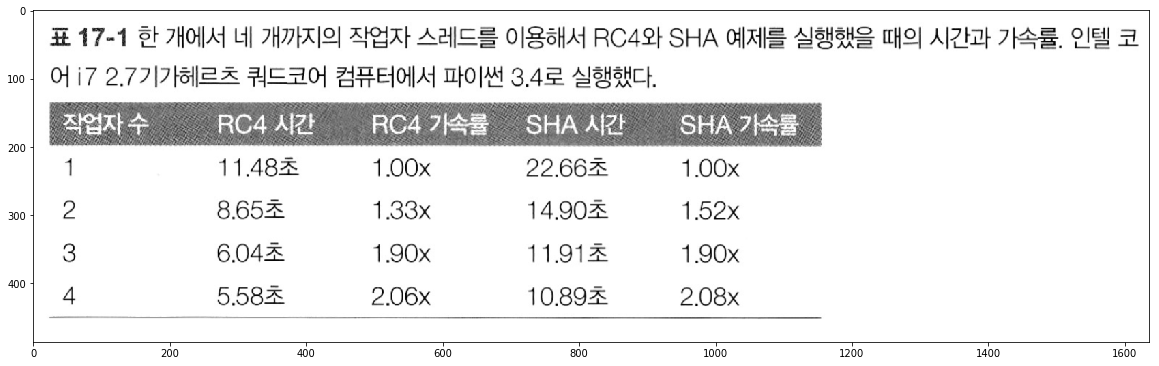

In [30]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
img=mpimg.imread('compare.png')
imgplot = plt.imshow(img)

> 계산 위주의 처리는 PyPy(https://pypy.org/)을 사용하면 더 효율적이다. CPython 4개의 작업자 프로세스보다 3.8배 정도 빠르다.

## 17.4 Executor.map()의 실험

map()이 작동하는 과정을 자세히 보여준다.

In [31]:
! cat demo_executor_map.py

from time import sleep, strftime
from concurrent import futures


def display(*args):
    print(strftime('[%H:%M:%S]'), end=' ')
    print(*args)


def loiter(n):
    msg = '{}loiter({}): doing nothing for {}s...'
    display(msg.format('\t' * n, n, n))
    sleep(n)
    msg = '{}loiter({}): done.'
    display(msg.format('\t' * n, n))
    return n * 10


def main():
    display('Script starting.')
    executor = futures.ThreadPoolExecutor(max_workers=3)
    results = executor.map(loiter, range(5))
    display('results:', results)
    display('Waiting for individual results:')
    for i, result in enumerate(results):
        display('result {}: {}'.format(i, result))


main()


In [32]:
! python3 demo_executor_map.py

[16:32:46] Script starting.
[16:32:46] loiter(0): doing nothing for 0s...
[16:32:46] loiter(0): done.
[16:32:46] 	loiter(1): doing nothing for 1s...
[16:32:46] 		loiter(2): doing nothing for 2s...
[16:32:46] results: <generator object Executor.map.<locals>.result_iterator at 0x1013514c0>
[16:32:46] Waiting for individual results:
[16:32:46] result 0: 0
[16:32:46] 			loiter(3): doing nothing for 3s...
[16:32:47] 	loiter(1): done.
[16:32:47] 				loiter(4): doing nothing for 4s...
[16:32:47] result 1: 10
[16:32:48] 		loiter(2): done.
[16:32:48] result 2: 20
[16:32:49] 			loiter(3): done.
[16:32:49] result 3: 30
[16:32:51] 				loiter(4): done.
[16:32:51] result 4: 40


map은 요청한 순서대로 결과를 가져오는 장점과 사용하기 쉬운 장점이 있지만, 

처음 요청한 작업이 10초, 나머지 작업이 1초 걸린다 하더라도, 10초 이후에 해당 결과값을 나타낼 수 있다.

이런 경우를 해결하기 위해, 요청한 순서와 관계없이 결과값을 가져오는 Executor.submit()과 futures.as_completed() 함수를 함께 사용해야 한다.

>**submit()은 다양한 콜러블을 이용해서 결과를 가져올 수 있다. 그러나 map()의 경우 하나의 콜러블에 대해서만 결과를 가져올 수 있어 융통성이 submit이 더 높다.**

## 17.5 진행 상황 출력하고 에러를 처리하며 내려받기

In [72]:
! cat flags2_common.py

import os
import time
import sys
import string
import argparse
from collections import namedtuple
from enum import Enum


Result = namedtuple('Result', 'status data')

HTTPStatus = Enum('Status', 'ok not_found error')

POP20_CC = ('CN IN US ID BR PK NG BD RU JP '
            'MX PH VN ET EG DE IR TR CD FR').split()

DEFAULT_CONCUR_REQ = 1
MAX_CONCUR_REQ = 1

SERVERS = {
    'REMOTE': 'http://flupy.org/data/flags',
    'LOCAL':  'http://localhost:8001/flags',
    'DELAY':  'http://localhost:8002/flags',
    'ERROR':  'http://localhost:8003/flags',
}
DEFAULT_SERVER = 'LOCAL'

DEST_DIR = 'downloads/'
COUNTRY_CODES_FILE = 'country_codes.txt'


def save_flag(img, filename):
    path = os.path.join(DEST_DIR, filename)
    with open(path, 'wb') as fp:
        fp.write(img)


def initial_report(cc_list, actual_req, server_label):
    if len(cc_list) <= 10:
        cc_msg = ', '.join(cc_list)
    else:
        cc_msg = 'from {} to {}'.format(cc_list[0], cc_list[-1])
    print('{} site: {}'.form

> 테스트를 위한 공용 파일

In [71]:
! cat flags2_sequential.py

import collections

import requests
import tqdm

from flags2_common import main, save_flag, HTTPStatus, Result

DEFAULT_CONCUR_REQ = 1
MAX_CONCUR_REQ = 1


def get_flag(base_url, cc):
    url = '{}/{cc}/{cc}.gif'.format(base_url, cc=cc.lower())
    resp = requests.get(url)
    if resp.status_code != 200:
        resp.raise_for_status()
    return resp.content


def download_one(cc, base_url, verbose=False):
    try:
        image = get_flag(base_url, cc)
    except requests.exceptions.HTTPError as exc:
        res = exc.response
        if res.status_code == 404:
            status = HTTPStatus.not_found
            msg = 'not found'
        else:
            raise
    else:
        save_flag(image, cc.lower() + '.gif')
        status = HTTPStatus.ok
        msg = 'OK'

    if verbose:
        print(cc, msg)

    return Result(status, cc)


def download_many(cc_list, base_url, verbose, max_req):
    counter = collections.Counter()
    cc_iter = sorted(cc_list)
    if not verbose:
     

> 순차 HTTP 클라이언트

In [69]:
! cat flags2_threadpool.py

import collections
from concurrent import futures

import requests
import tqdm

from flags2_common import main, HTTPStatus
from flags2_sequential import download_one

DEFAULT_CONCUR_REQ = 30
MAX_CONCUR_REQ = 1000


def download_many(cc_list, base_url, verbose, concur_req):
    counter = collections.Counter()
    with futures.ThreadPoolExecutor(max_workers=concur_req) as executor:
        to_do_map = {}
        for cc in sorted(cc_list):
            future = executor.submit(download_one,
                                     cc, base_url, verbose)
            to_do_map[future] = cc
        done_iter = futures.as_completed(to_do_map)
        if not verbose:
            done_iter = tqdm.tqdm(done_iter, total=len(cc_list))
        for future in done_iter:
            try:
                res = future.result()
            except requests.exceptions.HTTPError as exc:
                error_msg = 'HTTP {res.status_code} - {res.reason}'
                error_msg = error_msg.format(res=exc.respon

> ThreadPool 기반 동시성 HTTP 클라이언트

In [70]:
! cat flags2_asyncio.py

import asyncio
import collections
import contextlib

import aiohttp
from aiohttp import web
import tqdm

from flags2_common import main, HTTPStatus, Result, save_flag

DEFAULT_CONCUR_REQ = 5
MAX_CONCUR_REQ = 1000


class FetchError(Exception):
    def __init__(self, country_code):
        self.country_code = country_code


@asyncio.coroutine
def get_flag(base_url, cc):
    url = '{}/{cc}/{cc}.gif'.format(base_url, cc=cc.lower())
    resp = yield from aiohttp.request('GET', url)
    with contextlib.closing(resp):
        if resp.status == 200:
            image = yield from resp.read()
            return image
        elif resp.status == 404:
            raise web.HTTPNotFound()
        else:
            raise aiohttp.HttpProcessingError(
                code=resp.status, message=resp.reason,
                headers=resp.headers)


@asyncio.coroutine
def download_one(cc, base_url, semaphore, verbose):
    try:
        with (yield from semaphore):
            image = yield from get_flag(

> asyncio, aiohttp를 이용해서 구현 18.4절

TQDM 패키지(https://github.com/noamraph/tqdm)

모든 형태의 반복형을 인수로 받아 처리를 하면서 진행 막대로 완료되기까지 남은 시간을 추정해서 보여준다.

완료되기까지 남은 시간을 추정해서 보여주기 위해 tqdm()은 len()을 지원하는 반복형을 받거나, 예상 항목 수를 두 번째 인수로 받는다.

In [76]:
! python3 flags2_threadpool.py -h

usage: flags2_threadpool.py [-h] [-a] [-e] [-l N] [-m CONCURRENT] [-s LABEL]
                            [-v]
                            [CC [CC ...]]

Download flags for country codes. Default: top 20 countries by population.

positional arguments:
  CC                    country code or 1st letter (eg. B for BA...BZ)

optional arguments:
  -h, --help            show this help message and exit
  -a, --all             get all available flags (AD to ZW)
  -e, --every           get flags for every possible code (AA...ZZ)
  -l N, --limit N       limit to N first codes
  -m CONCURRENT, --max_req CONCURRENT
                        maximum concurrent requests (default=30)
  -s LABEL, --server LABEL
                        Server to hit; one of DELAY, ERROR, LOCAL, REMOTE
                        (default=LOCAL)
  -v, --verbose         output detailed progress info


--server

> **Local**: 8001/flags

> **Remote**: flupy.org/data/flags 필자가 제공하는 외부 서버

> **DELAY**: 8002/flags

> **ERROR**: 8003/flags

해당 서버를 구현하려면 세팅이 필요한데 아래처럼 세팅하면된다.

In [38]:
! cat countries/README.rst

Setting up Nginx and Vaurien

This text explains how to configure Nginx and Vaurien to test HTTP client code while avoiding network traffic and introducing simulated delays and errors. This setup is necessary if you want to experiment with the ``flags2*.py`` image download examples in this directory -- covered in chapters 17 and 18 of Fluent Python.


Overview

The flag download examples are designed to compare the performance of different approaches to finding and downloading files from the Web. However, we don't want to hit a public server with multiple requests per second while testing, and we want to be able to simulate high latency and random network errors.

For this setup I chose Nginx as the HTTP server because it is very fast and easy to configure, and the Vaurien proxy because it was designed by Mozilla to introduce delays and network errors for testing Web services.

The archive ``flags.zip``, contains a directory ``flags/`` with 194 subdirectories, each containing a ``.gif`

In [78]:
! python3 flags2_sequential.py

LOCAL site: http://localhost:8001/flags
Searching for 20 flags: from BD to VN
1 concurrent connection will be used.
100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 313.00it/s]
--------------------
0 flags downloaded.
20 errors.
Elapsed time: 0.07s


In [79]:
! python3 flags2_threadpool.py -s DELAY a b c

DELAY site: http://localhost:8002/flags
Searching for 78 flags: from AA to CZ
30 concurrent connections will be used.
100%|████████████████████████████████████████| 78/78 [00:00<00:00, 11093.78it/s]
--------------------
0 flags downloaded.
78 errors.
Elapsed time: 0.19s


In [49]:
! python3 flags2_asyncio.py -s ERROR -al 100 -m 100

ERROR site: http://localhost:8003/flags
Searching for 100 flags: from AD to LK
100 concurrent connections will be used.
  0%|                                                   | 0/100 [00:00<?, ?it/s]Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x1087291d0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729160>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729208>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x1087292b0>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729320>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729390>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729400>
Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x108729470>
Unclosed client session
client_session: <aiohttp.client.

## 17.5.1 flags2 예제에서의 에러 처리

download_one() 함수가 404(Not Found) 에러를 처리한다.

```python
Result = namedtuple('Result', 'status data')

HTTPStatus = Enum('Status', 'ok not_found error')

def get_flag(base_url, cc):
    url = '{}/{cc}/{cc}.gif'.format(base_url, cc=cc.lower())
    resp = requests.get(url)
    if resp.status_code != 200:
        resp.raise_for_status() # 에러를 발생 시킨다.
    return resp.content


def download_one(cc, base_url, verbose=False):
    try:
        image = get_flag(base_url, cc)
    except requests.exceptions.HTTPError as exc: 
        res = exc.response
        if res.status_code == 404: # 404 코드만 처리
            status = HTTPStatus.not_found
            msg = 'not found'
        else:
            raise
    else:
        save_flag(image, cc.lower() + '.gif')
        status = HTTPStatus.ok
        msg = 'OK'

    if verbose:
        print(cc, msg)

    return Result(status, cc)
```                    

```python
def download_many(cc_list, base_url, verbose, max_req):
    counter = collections.Counter()  # 합계를 각각 구한다.
    cc_iter = sorted(cc_list)
    if not verbose:
        cc_iter = tqdm.tqdm(cc_iter)  # tqdm을 사용하기 위해 반복자를 인수로 넣어준다.
    for cc in cc_iter:
        try:
            res = download_one(cc, base_url, verbose)
        except requests.exceptions.HTTPError as exc:  # download_one()에서 처리되지 않은 에러를 처리
            error_msg = 'HTTP error {res.status_code} - {res.reason}'
            error_msg = error_msg.format(res=exc.response)
        except requests.exceptions.ConnectionError as exc:  # 다른 네트워크 관련 에러 처리
            error_msg = 'Connection error'
        else:  # 에러가 발생하지 않은 경우
            error_msg = ''
            status = res.status

        if error_msg:
            status = HTTPStatus.error
        counter[status] += 1  # 각값에 대한 카운터 증가
        if verbose and error_msg:
            print('*** Error for {}: {}'.format(cc, error_msg))

    return counter
```                                

## 17.5.2 futures.as_completed() 사용하기

In [77]:
import collections
from concurrent import futures

import requests
import tqdm

from flags2_common import main, HTTPStatus
from flags2_sequential import download_one

DEFAULT_CONCUR_REQ = 30
MAX_CONCUR_REQ = 1000


def download_many(cc_list, base_url, verbose, concur_req):
    counter = collections.Counter()
    with futures.ThreadPoolExecutor(max_workers=concur_req) as executor:
        to_do_map = {}
        for cc in sorted(cc_list):
            future = executor.submit(download_one,
                                     cc, base_url, verbose)
            to_do_map[future] = cc # 순차적으로 진행되지 않으므로, 국가코드와 매칭시킨다. 임의의 순서대로 완료되더라도 Future 객체의 결과를 가져와 처리가 쉽다.
        done_iter = futures.as_completed(to_do_map)
        if not verbose:
            done_iter = tqdm.tqdm(done_iter, total=len(cc_list)) # done_iter에는 len이 없으므로, total을 알려줘야 작업 진행에 대한 예상이 가능하다.
        for future in done_iter:
            try:
                res = future.result() # callable의 반환한 값이나, callable의 에러를 반환한다.
            except requests.exceptions.HTTPError as exc:
                error_msg = 'HTTP {res.status_code} - {res.reason}'
                error_msg = error_msg.format(res=exc.response)
            except requests.exceptions.ConnectionError as exc:
                error_msg = 'Connection error'
            else:
                error_msg = ''
                status = res.status

            if error_msg:
                status = HTTPStatus.error
            counter[status] += 1
            if verbose and error_msg:
                cc = to_do_map[future]
                print('*** Error for {}: {}'.format(cc, error_msg))

    return counter

## 17.5.3 스레드 및 멀티프로세스의 대안

### 쓰레드

ThreadPoolExecutor로 처리하기 어려운 경우, Thread, Lock, Semaphore 등 **threading 모듈**의 기본 컴포넌트를 이용해서 처리할 수 있다.

Thread간 데이터 전송은 Queue 모듈로 안전하게 이용할 수 있다.

이 컴포넌트들은 futures.ThreadPoolExecutor에 캡슐화되어 있다.


### 프로세스

계산 위주의 작업은 여러 프로세스를 실행해서 GIL을 피해나가야 한다.

ProcessPoolExecutor를 이용하기 어려운 경우, multiprocessing 패키지를 사용해야 한다.

## 17.6 요약

- **ProcessPoolExecutor: 계산, CPU**

- **ThreadPoolExecutor: 입출력, 메모리**

- **map 보단 Executor.submit, as_completed() 를 이용하자**

- threading과 multiprocessing 모듈을 이용해서도 동시성 작업을 처리할 수 있다.

## 17.7 읽을거리

- Future는 java의 영향을 많이 받았다.
- 분산 작업 큐인 Celery 라이브러리(장고 커뮤니티에서 PDF 생성 등 무거운 작업을 다른 프로세스로 덜어내서 HTTP 응답 지연을 줄이기 위해 많이 사용)
- multiprocessing 패키지는 ProcessPoolExecutor의 기반.

- python-parallelize 라이브러리(http://bit.ly/1HGtF6Q)
- lelo 라이브러리(https://pypi.python.org/pypi/lelo)